Found 100 sample locations in CSV


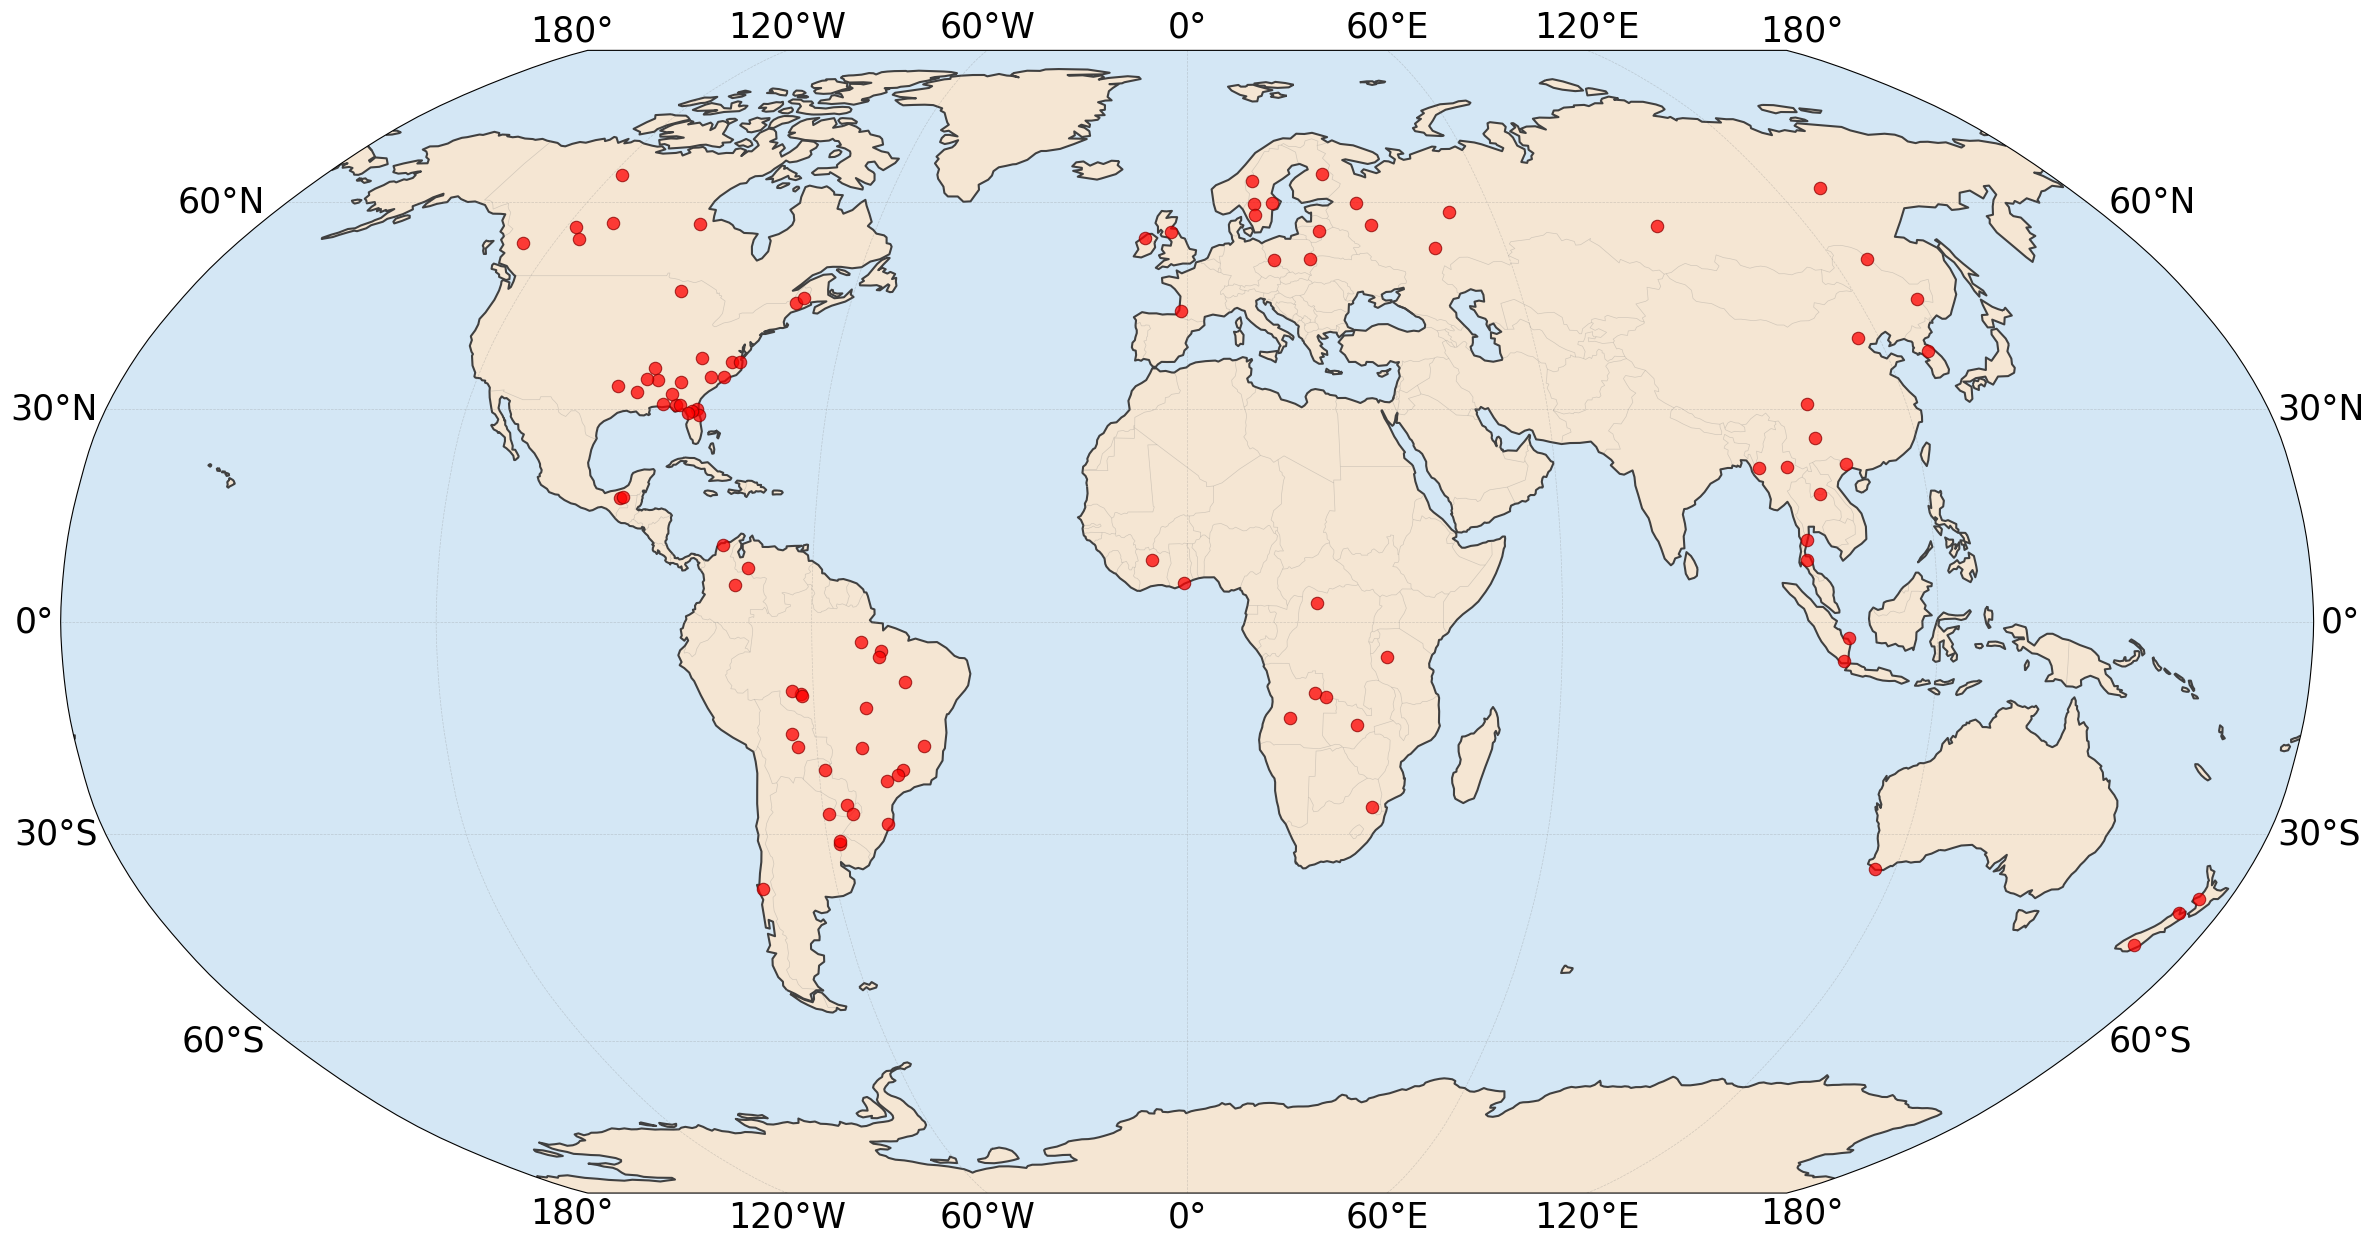


Summary Statistics:
Total samples: 100
Longitude range: -125.81° to 174.67°
Latitude range: -45.67° to 64.33°


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# UPDATE: path to the CSV generated by the cleaning script
csv_path = r"G:\Hangkai\Global_Forest_edge_mapping_data\Validation_Samples\validation_samples_geolocation_summary.csv"

# Read CSV
df = pd.read_csv(csv_path)

# Make sure lon/lat are numeric (sometimes read as strings)
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")

# Drop rows without valid coords and filter ranges
df = df.dropna(subset=["longitude", "latitude"])
df = df[(df["longitude"].between(-180, 180)) & (df["latitude"].between(-90, 90))]

print(f"Found {len(df)} sample locations in CSV")

# --- Plot ---
fig = plt.figure(figsize=(24, 14))
ax = plt.axes(projection=ccrs.Robinson())

# Background
ax.add_feature(cfeature.OCEAN, facecolor="#D4E7F5", zorder=0)
ax.add_feature(cfeature.LAND, facecolor="#F5E6D3", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor="#404040", zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="gray", alpha=0.3, zorder=2)

# Gridlines (labels on Robinson can look busy; keep if you like)
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="gray", alpha=0.3, linestyle="--",
    x_inline=False, y_inline=False
)
gl.top_labels = True
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlabel_style = {"size": 25, "color": "black"}
gl.ylabel_style = {"size": 25, "color": "black"}

# Scatter points
ax.scatter(
    df["longitude"].values,
    df["latitude"].values,
    transform=ccrs.PlateCarree(),
    c="red",
    s=80,
    alpha=0.75,
    edgecolor="#8B0000",
    linewidth=0.8,
    zorder=10
)

ax.set_global()
plt.tight_layout()
plt.show()

# Summary stats
print("\nSummary Statistics:")
print(f"Total samples: {len(df)}")
print(f"Longitude range: {df['longitude'].min():.2f}° to {df['longitude'].max():.2f}°")
print(f"Latitude range: {df['latitude'].min():.2f}° to {df['latitude'].max():.2f}°")

In [2]:
"""
Forest Edge Validation Sample Geographic Distribution Analysis
Statistics by Continents and Climate Zones

Usage:
1. Save this script to your computer
2. Modify the output_folder path below to your actual path
3. Run the script: python analyze_continental_climate_distribution.py
"""

import os
import re
import matplotlib.pyplot as plt
import numpy as np

# ===== MODIFY THIS PATH =====
output_folder = r"G:\Hangkai\Global Forest Edge Other Data\validation_samples_0p01deg_per_sample_folder\samples\output"
# ============================

# Define continental boundaries (based on longitude and latitude)
# More precise continental classification
def classify_continent(lon, lat):
    """
    Classify a point into a continent based on longitude and latitude
    """
    # Antarctica
    if lat < -60:
        return 'Antarctica'
    
    # Americas (Western Hemisphere, roughly)
    if -180 <= lon < -30:
        if lat >= 15:
            return 'North America'
        else:
            return 'South America'
    
    # Europe
    if -30 <= lon < 40 and lat >= 35:
        return 'Europe'
    
    # Africa
    if -20 <= lon < 55 and -35 < lat < 38:
        return 'Africa'
    
    # Asia (including Middle East)
    if 25 <= lon < 180 and lat >= 8:
        # Separate Oceania from Asia
        if lon >= 110 and lat < 25:
            # Check if it's Australia/Oceania
            if 110 <= lon <= 180 and -50 <= lat < 25:
                return 'Oceania'
        return 'Asia'
    
    # Oceania (Australia, Pacific Islands, Indonesia, etc.)
    if 95 <= lon <= 180 and -50 <= lat < 25:
        return 'Oceania'
    
    # Default fallback
    if lon >= 40 and lat < 8:
        return 'Asia'  # Southeast Asia
    
    return 'Unknown'


def classify_climate_zone(lat):
    """
    Classify a point into climate zones based on latitude
    
    Climate zones:
    - Tropical: 0° to 23.5° (North and South)
    - Subtropical: 23.5° to 35°
    - Temperate: 35° to 66.5°
    - Polar/Cold: 66.5° to 90°
    """
    abs_lat = abs(lat)
    
    if abs_lat <= 23.5:
        return 'Tropical (0-23.5°)'
    elif abs_lat <= 35:
        return 'Subtropical (23.5-35°)'
    elif abs_lat <= 66.5:
        return 'Temperate (35-66.5°)'
    else:
        return 'Polar/Cold (>66.5°)'


def classify_hemisphere(lat):
    """Classify into Northern or Southern hemisphere"""
    if lat >= 0:
        return 'Northern Hemisphere'
    else:
        return 'Southern Hemisphere'


# Store coordinates and metadata for all samples
lons = []
lats = []
sample_ids = []

# Traverse all subfolders
print("Reading sample data...")
for subfolder in os.listdir(output_folder):
    subfolder_path = os.path.join(output_folder, subfolder)
    
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Look for meta.txt file
        meta_file = os.path.join(subfolder_path, "meta.txt")
        
        if os.path.exists(meta_file):
            # Read meta file
            with open(meta_file, 'r', encoding='utf-8') as f:
                content = f.read()
                
                # Extract sample_id
                sample_id_match = re.search(r'sample_id:\s*(\d+)', content)
                
                # Extract class
                class_match = re.search(r'class:\s*(\w+)', content)
                
                # Extract center coordinates
                coord_match = re.search(r'center_lon,\s*center_lat:\s*([-\d.]+),\s*([-\d.]+)', content)
                
                if coord_match:
                    lon = float(coord_match.group(1))
                    lat = float(coord_match.group(2))
                    lons.append(lon)
                    lats.append(lat)
                    
                    if sample_id_match:
                        sample_ids.append(int(sample_id_match.group(1)))
                    else:
                        sample_ids.append(len(sample_ids))
                    

print(f"✓ Successfully read {len(lons)} samples")

if len(lons) == 0:
    print("Error: No sample data found!")
    print(f"Please check if the path is correct: {output_folder}")
    exit(1)

# Classify all samples
continents = []
climate_zones = []
hemispheres = []

for lon, lat in zip(lons, lats):
    continents.append(classify_continent(lon, lat))
    climate_zones.append(classify_climate_zone(lat))
    hemispheres.append(classify_hemisphere(lat))

# ========== Statistical Analysis ==========
print("\n" + "="*80)
print("GEOGRAPHIC AND CLIMATE DISTRIBUTION ANALYSIS")
print("="*80)

# Total samples
print(f"\nTotal samples: {len(lons)}")

# ========== Continental Distribution ==========
print("\n" + "-"*80)
print("CONTINENTAL DISTRIBUTION")
print("-"*80)

continent_counts = {}
for cont in continents:
    continent_counts[cont] = continent_counts.get(cont, 0) + 1

print(f"\n{'Continent':<25} {'Count':<10} {'Percentage':<15}")
print("-"*50)
for cont, count in sorted(continent_counts.items(), key=lambda x: -x[1]):
    percentage = count / len(lons) * 100
    print(f"{cont:<25} {count:<10} {percentage:>6.2f}%")

# ========== Climate Zone Distribution ==========
print("\n" + "-"*80)
print("CLIMATE ZONE DISTRIBUTION")
print("-"*80)

climate_counts = {}
for zone in climate_zones:
    climate_counts[zone] = climate_counts.get(zone, 0) + 1

# Order by latitude (tropical to polar)
zone_order = [
    'Tropical (0-23.5°)',
    'Subtropical (23.5-35°)',
    'Temperate (35-66.5°)',
    'Polar/Cold (>66.5°)'
]

print(f"\n{'Climate Zone':<30} {'Count':<10} {'Percentage':<15}")
print("-"*60)
for zone in zone_order:
    if zone in climate_counts:
        count = climate_counts[zone]
        percentage = count / len(lons) * 100
        print(f"{zone:<30} {count:<10} {percentage:>6.2f}%")

# ========== Hemisphere Distribution ==========
print("\n" + "-"*80)
print("HEMISPHERE DISTRIBUTION")
print("-"*80)

hemisphere_counts = {}
for hemi in hemispheres:
    hemisphere_counts[hemi] = hemisphere_counts.get(hemi, 0) + 1

print(f"\n{'Hemisphere':<25} {'Count':<10} {'Percentage':<15}")
print("-"*50)
for hemi, count in sorted(hemisphere_counts.items()):
    percentage = count / len(lons) * 100
    print(f"{hemi:<25} {count:<10} {percentage:>6.2f}%")

# ========== Cross-tabulation: Continent × Climate Zone ==========
print("\n" + "-"*80)
print("CONTINENT × CLIMATE ZONE CROSS-TABULATION")
print("-"*80)

# Create cross-tabulation dictionary
cross_tab = {}
for cont, zone in zip(continents, climate_zones):
    if cont not in cross_tab:
        cross_tab[cont] = {}
    cross_tab[cont][zone] = cross_tab[cont].get(zone, 0) + 1

# Print cross-tabulation
print(f"\n{'Continent':<20}", end='')
for zone in zone_order:
    print(f"{zone:<20}", end='')
print(f"{'Total':<10}")
print("-"*120)

for cont in sorted(continent_counts.keys(), key=lambda x: -continent_counts[x]):
    print(f"{cont:<20}", end='')
    total = 0
    for zone in zone_order:
        count = cross_tab.get(cont, {}).get(zone, 0)
        total += count
        if count > 0:
            print(f"{count:<20}", end='')
        else:
            print(f"{'-':<20}", end='')
    print(f"{total:<10}")

Reading sample data...
✓ Successfully read 100 samples

GEOGRAPHIC AND CLIMATE DISTRIBUTION ANALYSIS

Total samples: 100

--------------------------------------------------------------------------------
CONTINENTAL DISTRIBUTION
--------------------------------------------------------------------------------

Continent                 Count      Percentage     
--------------------------------------------------
North America             30          30.00%
South America             26          26.00%
Asia                      16          16.00%
Europe                    13          13.00%
Africa                    9            9.00%
Oceania                   6            6.00%

--------------------------------------------------------------------------------
CLIMATE ZONE DISTRIBUTION
--------------------------------------------------------------------------------

Climate Zone                   Count      Percentage     
------------------------------------------------------------
Tropica